In [1]:
import pandas as pd
from pyopenms import MzMLFile, MSExperiment, OnDiscMSExperiment
import numpy as np
import re
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
mod_acetyl = ("acetyl","K(UniMod:1)")
mod_biotin = ("biotin","K(UniMod:3)")
mod_dimethyl = ("dimethyl","K(UniMod:36)")
mod_hydroxy = ("hydroxy","P(UniMod:35)")
mod_oxid = ("oxid","P(UniMod:35)")
mod_methyl = ("methyl","K(UniMod:34)")
mod_nitro = ("nitro","Y(UniMod:354)")
mod_phospho = ("phospho","Y(UniMod:21)")

In [3]:
def fix_decoy_report(df):
    df.loc[:, "Q.Value"] = pd.to_numeric(df["Precursor.Id"])
    df.loc[:, "Precursor.Id"] = df["Modified.Sequence"]
    df.loc[:, "CScore"] = df["RT.Start"]

In [70]:
def fdrs_for_cscores(targets_df, decoys_df):
    fdrs = []
    cscores = np.sort(np.concatenate([decoys_df["CScore"], targets_df["CScore"]]))[::-1]

    for cscore in cscores:
        fdr = (decoys_df["CScore"] > cscore).sum() / (targets_df["CScore"] > cscore).sum()
        fdrs.append(fdr)
    return fdrs, cscores

In [45]:
def get_mods_unmods_all(result_dir, mods):
    mods_results = {}
    for mod_name, mod_unimod in mods:
        df_mod_subset = pd.read_csv(f"{result_dir}/report_{mod_unimod}.tsv", delimiter="\t")

        # to account for mismatching columns in result tsv for decoys
        df_mod_subset_decoys = df_mod_subset[df_mod_subset["Q.Value"].isna()]
        fix_decoy_report(df_mod_subset_decoys)
        
        df_mod_subset_targets = df_mod_subset[~df_mod_subset["Q.Value"].isna()]

        if mod_name == "hydroxy":
            mod_name = "oxid"
        mods_results[(mod_name, mod_unimod)] = {"targets": df_mod_subset_targets, "decoys": df_mod_subset_decoys}
    
    df_unmod_subset = pd.read_csv(f"{result_dir}/report_unmodified.tsv", delimiter="\t")
    # to account for mismatching columns in result tsv for decoys
    df_unmod_subset_decoys = df_unmod_subset[df_unmod_subset["Q.Value"].isna()]
    fix_decoy_report(df_unmod_subset_decoys)
    df_unmod_subset_targets = df_unmod_subset[~df_unmod_subset["Q.Value"].isna()]

    all_mods_targets = pd.concat([mod_result["targets"] for mod_result in mods_results.values()], ignore_index=True)
    all_mods_decoys = pd.concat([mod_result["decoys"] for mod_result in mods_results.values()], ignore_index=True)

    all_targets = pd.concat([all_mods_targets, df_unmod_subset_targets], ignore_index=True)
    all_decoys = pd.concat([all_mods_decoys, df_unmod_subset_decoys], ignore_index=True)

    return mods_results, all_mods_targets, all_mods_decoys, df_unmod_subset_targets, df_unmod_subset_decoys, all_targets, all_decoys

In [53]:
def plot_densities(targets_df, decoys_df):
    plt.figure()
    decoys_df["CScore"].plot.kde()
    targets_df["CScore"].plot.kde()

In [66]:
mods_results_mod, all_mods_targets_mod, all_mods_decoys_mod, all_unmods_targets_mod, all_unmods_decoys_mod, all_targets_mod, all_decoys_mod = get_mods_unmods_all(
    "../../data/workflow_test_tolerance_snr3_10ppm_all_mods_with_decoys",
    [mod_acetyl, mod_biotin, mod_dimethyl, mod_hydroxy, mod_methyl, mod_nitro, mod_phospho])

/tmp/ipykernel_7117/2865531697.py:4: DtypeWarning: Columns (5,11,12,14,15,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mod_subset = pd.read_csv(f"{result_dir}/report_{mod_unimod}.tsv", delimiter="\t")
/tmp/ipykernel_7117/2865531697.py:4: DtypeWarning: Columns (5,14,15,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mod_subset = pd.read_csv(f"{result_dir}/report_{mod_unimod}.tsv", delimiter="\t")
/tmp/ipykernel_7117/2865531697.py:16: DtypeWarning: Columns (5,14,15,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_unmod_subset = pd.read_csv(f"{result_dir}/report_unmodified.tsv", delimiter="\t")


In [71]:
fdrs_mod, cscores_mod = fdrs_for_cscores(all_targets_mod, all_decoys_mod)

/tmp/ipykernel_7117/780534136.py:7: RuntimeWarning: invalid value encountered in scalar divide
  fdr = num_decoys / (num_decoys + (targets_df["CScore"] > cscore).sum())


Text(0, 0.5, 'FDR')

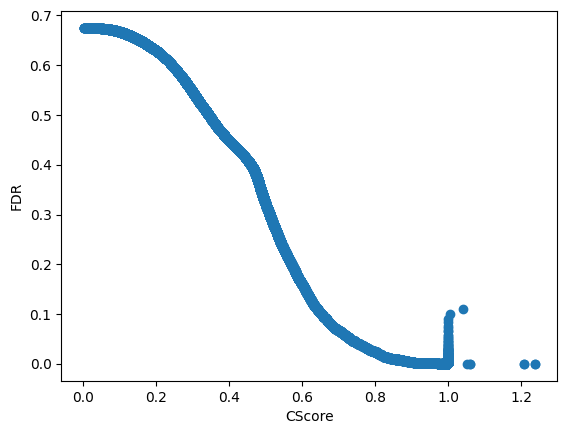

In [72]:
plt.scatter(cscores_mod, fdrs_mod)
plt.xlabel("CScore")
plt.ylabel("FDR")

In [73]:
cscore_1_percent_fdr = np.array(cscores_mod)[np.array(fdrs_mod) <= 0.01].min()
cscore_1_percent_fdr

0.84762

In [74]:
for mod_name, mod_unimod in [mod_acetyl, mod_biotin, mod_dimethyl, mod_oxid, mod_methyl, mod_nitro, mod_phospho]:
    print(mod_name)
    print(all_mods_targets_mod[all_mods_targets_mod["CScore"] >= cscore_1_percent_fdr]["Modified.Sequence"].str.contains(re.escape(mod_unimod)).sum())

acetyl
318
biotin
87
dimethyl
10
oxid
594
methyl
387
nitro
156
phospho
271


In [ ]:
plot_densities(all_targets_mod, all_decoys_mod)
plot_densities(all_mods_targets_mod, all_mods_decoys_mod)
plot_densities(all_unmods_targets_mod, all_unmods_decoys_mod)

# plt.hist(all_decoys["CScore"], bins=np.arange(0, 1.5, 0.01), label="decoys")
# plt.hist(all_targets["CScore"], bins=np.arange(0, 1.5, 0.01), label="targets", alpha=0.8)

In [56]:
mods_results_unmod, all_mods_targets_unmod, all_mods_decoys_unmod, all_unmods_targets_unmod, all_unmods_decoys_unmod, all_targets_unmod, all_decoys_unmod = get_mods_unmods_all(
    "../../data/workflow_test_tolerance_snr3_10ppm_unmod",
    [mod_acetyl, mod_dimethyl, mod_hydroxy, mod_methyl, mod_nitro, mod_phospho])

/tmp/ipykernel_7117/2865531697.py:4: DtypeWarning: Columns (5,11,12,14,15,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mod_subset = pd.read_csv(f"{result_dir}/report_{mod_unimod}.tsv", delimiter="\t")
/tmp/ipykernel_7117/2865531697.py:4: DtypeWarning: Columns (5,14,15,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mod_subset = pd.read_csv(f"{result_dir}/report_{mod_unimod}.tsv", delimiter="\t")
/tmp/ipykernel_7117/2865531697.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_mods_targets = pd.concat([mod_result["targets"] for mod_result in mods_results.values()], ignore_index=True)
/tmp/ipykernel_7117/2865531697.py:23: FutureWarning: The behavior of 

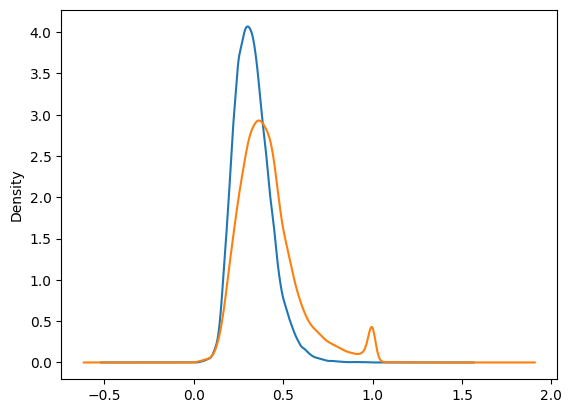

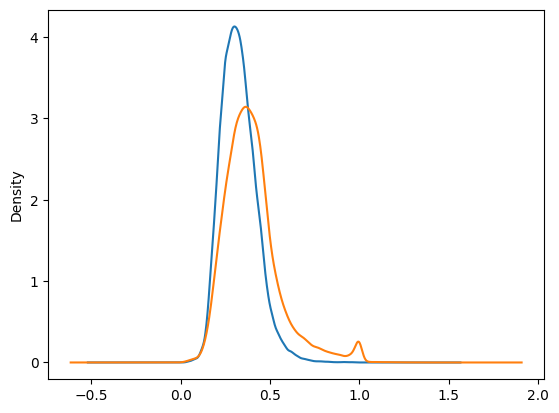

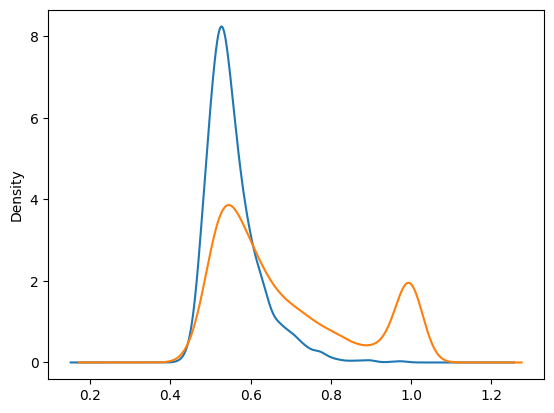

In [57]:
plot_densities(all_targets_unmod, all_decoys_unmod)
plot_densities(all_mods_targets_unmod, all_mods_decoys_unmod)
plot_densities(all_unmods_targets_unmod, all_unmods_decoys_unmod)

In [58]:
fdrs_unmod, cscores_unmod = fdrs_for_cscores(all_targets_unmod, all_decoys_unmod)

/tmp/ipykernel_7117/1445082166.py:6: RuntimeWarning: invalid value encountered in scalar divide
  fdr = (decoys_df["CScore"] > cscore).sum() / (targets_df["CScore"] > cscore).sum()


Text(0, 0.5, 'FDR')

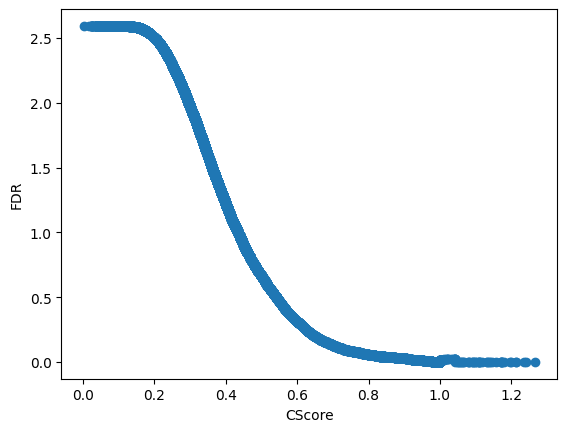

In [59]:
plt.scatter(cscores_unmod, fdrs_unmod)
plt.xlabel("CScore")
plt.ylabel("FDR")

In [60]:
cscore_1_percent_fdr_unmod = np.array(cscores_unmod)[np.array(fdrs_unmod) <= 0.01].min()
cscore_1_percent_fdr_unmod

0.955093

In [61]:
for mod_name, mod_unimod in [mod_acetyl, mod_dimethyl, mod_oxid, mod_methyl, mod_nitro, mod_phospho]:
    print(mod_name)
    print(all_mods_targets_unmod[all_mods_targets_unmod["CScore"] >= cscore_1_percent_fdr]["Modified.Sequence"].str.contains(re.escape(mod_unimod)).sum())

acetyl
144
dimethyl
0
oxid
10
methyl
6
nitro
1
phospho
0


In [64]:
(~all_targets_unmod[all_targets_unmod["CScore"] >= cscore_1_percent_fdr_unmod]["Modified.Sequence"].str.contains("UniMod")).sum()

1349

In [69]:
(~all_targets_mod[all_targets_mod["CScore"] >= cscore_1_percent_fdr]["Modified.Sequence"].str.contains("UniMod")).sum()

2946